# Forecast kidney diseases

## Goal

The goal of this project will be to read as many stuff of the data as possible and to visualize it as best as possible, find some patterns in the data like finding  a possible root cause of kidney diseases, the next step will be to prepare a model which will forecast if a person has kidney disease!

But first of all. lets start with the boring stuff, imports and reading the data:

In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf
import plotly.offline as pyo
import seaborn as sns
import matplotlib.pyplot as plt

pyo.init_notebook_mode()
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
data = pd.read_csv("kidney_disease.csv") 

# Replace them directly at the beginning to have persistent column names
data = data.rename(columns={  "bp": "blood_pressure"
                                                        , "sg": "weight"
                                                        , "al": "albumin"
                                                        , "su": "sugar"
                                                        , "rbc": "red_blood_cells"
                                                        , "pc": "pus_cell"
                                                        , "pcc": "pus_cell_clumps"
                                                        , "ba": "bacteria"
                                                        , "bgr": "blood_glucos_random"
                                                        , "bu": "blood_urea"
                                                        , "sc": "serum_creatinine"
                                                        , "sod": "sodium"
                                                        , "pot": "potassium"
                                                        , "hemo": "hemoglobin"
                                                        , "pcv": "packed_cell_volume"
                                                        , "wc": "white_blood_cell_count"
                                                        , "rc": "red_blood_cell_count"
                                                        , "htn": "hypertension"
                                                        , "dm": "diabetes_mellitus"
                                                        , "cad": "coronary_artery_disease"
                                                        , "appet": "appetite"
                                                        , "pe": "pedal_edema"
                                                        , "ane": "anemia"
})

In [3]:
data[data.columns[0:13]].head()

id   age  blood_pressure  weight  albumin  sugar red_blood_cells  pus_cell  \
0   0  48.0            80.0   1.020      1.0    0.0             NaN    normal   
1   1   7.0            50.0   1.020      4.0    0.0             NaN    normal   
2   2  62.0            80.0   1.010      2.0    3.0          normal    normal   
3   3  48.0            70.0   1.005      4.0    0.0          normal  abnormal   
4   4  51.0            80.0   1.010      2.0    0.0          normal    normal   

  pus_cell_clumps    bacteria  blood_glucos_random  blood_urea  \
0      notpresent  notpresent                121.0        36.0   
1      notpresent  notpresent                  NaN        18.0   
2      notpresent  notpresent                423.0        53.0   
3         present  notpresent                117.0        56.0   
4      notpresent  notpresent                106.0        26.0   

   serum_creatinine  
0               1.2  
1               0.8  
2               1.8  
3               3.8  
4               1.4

In [4]:
data[data.columns[13:26]].head()

sodium  potassium  hemoglobin packed_cell_volume white_blood_cell_count  \
0     NaN        NaN        15.4                 44                   7800   
1     NaN        NaN        11.3                 38                   6000   
2     NaN        NaN         9.6                 31                   7500   
3   111.0        2.5        11.2                 32                   6700   
4     NaN        NaN        11.6                 35                   7300   

  red_blood_cell_count hypertension diabetes_mellitus coronary_artery_disease  \
0                  5.2          yes               yes                      no   
1                  NaN           no                no                      no   
2                  NaN           no               yes                      no   
3                  3.9          yes                no                      no   
4                  4.6           no                no                      no   

  appetite pedal_edema anemia classification  
0     good          no     no            ckd  
1     good          no     no            ckd  
2     poor          no    yes            ckd  
3     poor         yes    yes            ckd  
4     good          no     no            ckd

### NaNs

We have multiple possibilities on how to treat NaN values:
* Drop NaN records
  * **Pros**: Easy and fast
  * **Cons**: If one column has a lot of NaNs and all the others not we will drop nearly all of our values
* Drop NaN columns:
  * **Pros**: Also very fast and easy
  * **Cons**: Might drop an important feature which might have helped us later
* Fill NaN values with mean, mode, median
  * **Pros**: Most of the time the best approach
  * **Cons**: More time consuming
  * **To be aware of**: 
    * The **mean** makes sense if our data is **normally distributed**
    * If we have a **lot of outliers** the **median** is the better approach
    * If we have a lot of **same values** or **categorical values**, the **mode** is the way to go!
* Backfilling/ Frontfilling
  * **Pros**: Fast and easy
  * **Cons**: No guarantee that what we filled makes sense

But before that. lets take a look at the nan values, we will get rid of them later on:

In [5]:
data.isnull().sum(axis = 0)

id                           0
age                          9
blood_pressure              12
weight                      47
albumin                     46
sugar                       49
red_blood_cells            152
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucos_random         44
blood_urea                  19
serum_creatinine            17
sodium                      87
potassium                   88
hemoglobin                  52
packed_cell_volume          70
white_blood_cell_count     105
red_blood_cell_count       130
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
pedal_edema                  1
anemia                       1
classification               0
dtype: int64

## Column Description

**id:** count of the entries in the dataset - preceding number  
**age:** age  
**blood_pressure/ bp:** blood pressure  
**weight/ sg:** specific gravity - weight  
**albumin/ al:** albumin  
**sugar/ su:** sugar  
**red_blood_cells/ rbc:** red blood cells  
**pus_cell/ pc:** pus cell *(Pus is the reponse of the body's to an infection, usually caused by bacteria)*  
**pus_cell_clumps/ pcc:** if clumbs of pus cells are present or not  
**bacteria/ ba:** if bacteria are present or not  
**blood_glucose_random/ bgr:** blood glucose random *(Amount of glucose or sugar circulating in a person's blood)*  
**blood_urea/ bu:** blood urea -   (Measures the amount of urea nitrogen that's in your blood)*  
**serum_creatinine/ sc:** serum creatinine  
**sodium/ sod:** sodium  
**potassium/ pot:** potassium  
**hemoglobin/ hemo:** hemoglobin is the iron-containing oxygen-transport metalloprotein in the red blood cells  
**packed_cell_volume/ pcv:** packed cell volume*(measures the volume percentage of red blood cells (RBC) in blood)*  
**white_blood_cell_count/ wc:** white blood cell count  
**red_blood_cell_count/ rc:** red blood cell count  
**hypertension/ htn:** hypertension *(is a long-term medical condition in which the blood pressure in the arteries is persistently elevated)*  
**diabetes_mellitus/ dm:** diabetes mellitus (the blood sugar level is pathologically elevated)  
**coronary_artery_disease/ cad:** coronary artery disease *(involves the reduction of blood flow to the heart muscle due to build-up of plaque in the arteries of the heart)*  
**appetite/ appet:** appetite *(How much hunger the person feels)*  
**pedal_edema/ pe:** pedal edema *(Pedal edema is the accumulation of fluid in the feet and lower legs)*  
**anemia/ ane:** anemia *( is a decrease in the total amount of red blood cells or hemoglobin in the blood, or a lowered ability of the blood to carry oxygen)*  
**classification:** class *(whether the patient has a kidney disease or not)*  

## Data cleaning


In [6]:
data.shape

(400, 26)

We have 400 datapoints in the dataset, not too many, specially if you consider that we have features which are nearly 1/3 na.
In general we have 3 possibilities on how to deal with missing datapoints:
1. ignore
2. drop
3. fill with the mean

I would suggest the third one, filling the missing datapoints with the mean of the existing values, of course this is not perfect as well, you could consider looking at a histogram to see how wide spread the data is and then decide again.

Even though the data was already cleaned for us, we wanna make some changes to the data so that we can work very well with the data:

1. Column names
   * As first thing I wanna renamn the columns to have a more palatable name, so it is easier to get which column was meant for which features instead of working only with the abbreviation *(this has already been done at the beginning to have persistent column names through the notebook*)
2. Numeric values
   * We wanna have as much things as possible as numbers, we can see correlations, highs and lows and stuff like that as good with non numeric data as we can with numeric data  
     * I alredy checked the data a bit and saw that following features, are numeric but have strings in them, so we have to do a little extra work to bring them to a numeric value and can calculate them mean
3. Categorical values
   * Our goal is it to have only numbers as features, lets check how many we can convert easily

In [7]:
features_to_fix = {'packed_cell_volume', 'red_blood_cell_count', 'white_blood_cell_count'}

for feature in features_to_fix:
    data[feature] = data[feature].apply(pd.to_numeric, errors='ignore')
    data[feature] = data[feature].apply(lambda x: 0 if str(type(x))=="<class 'str'>" else x)
    data[feature] = data[feature].fillna((data[feature].mean()))
    
from pandas.api.types import is_numeric_dtype

feature_list = data.columns.values.tolist()

for feature in feature_list: 
    if(is_numeric_dtype(data[feature])):
        data[feature] = data[feature].replace(np.nan, 0)
        data[feature] = data[feature].replace(0, data[feature].mean())
    else:
        print(feature + " NON NUMERIC")    

red_blood_cells NON NUMERIC
pus_cell NON NUMERIC
pus_cell_clumps NON NUMERIC
bacteria NON NUMERIC
hypertension NON NUMERIC
diabetes_mellitus NON NUMERIC
coronary_artery_disease NON NUMERIC
appetite NON NUMERIC
pedal_edema NON NUMERIC
anemia NON NUMERIC
classification NON NUMERIC


Following features are still not numeric, lets have a look at what is inside of this features:

In [8]:
feature_list = data.columns.values.tolist()

for feature in feature_list: 
    if(is_numeric_dtype(data[feature]) is False):
        data[feature] = data[feature].fillna((data[feature].value_counts()[data[feature].value_counts() == data[feature].value_counts().max()]))
    else:
        pass
    
data.isnull().sum(axis = 0)

id                           0
age                          0
blood_pressure               0
weight                       0
albumin                      0
sugar                        0
red_blood_cells            152
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucos_random          0
blood_urea                   0
serum_creatinine             0
sodium                       0
potassium                    0
hemoglobin                   0
packed_cell_volume           0
white_blood_cell_count       0
red_blood_cell_count         0
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
pedal_edema                  1
anemia                       1
classification               0
dtype: int64

The rest of the values are categorical features, and so little that we can ignore them, lets take a look at them anyway!

In [9]:
print(data.astype(str).groupby(['pus_cell_clumps']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['bacteria']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['diabetes_mellitus']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['coronary_artery_disease']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['appetite']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['pedal_edema']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['anemia']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['red_blood_cells']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['pus_cell_clumps']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['bacteria']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['hypertension']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['appetite']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['pedal_edema']).size().reset_index(name='count'))
print("-------")
print(data.astype(str).groupby(['anemia']).size().reset_index(name='count'))


print("-------")
print(data.astype(str).groupby(['pus_cell']).size().reset_index(name='count'))

  pus_cell_clumps  count
0             nan      4
1      notpresent    354
2         present     42
-------
     bacteria  count
0         nan      4
1  notpresent    374
2     present     22
-------
  diabetes_mellitus  count
0              \tno      3
1             \tyes      2
2               yes      1
3               nan      2
4                no    258
5               yes    134
-------
  coronary_artery_disease  count
0                    \tno      2
1                     nan      2
2                      no    362
3                     yes     34
-------
  appetite  count
0     good    317
1      nan      1
2     poor     82
-------
  pedal_edema  count
0         nan      1
1          no    323
2         yes     76
-------
  anemia  count
0    nan      1
1     no    339
2    yes     60
-------
  red_blood_cells  count
0        abnormal     47
1             nan    152
2          normal    201
-------
  pus_cell_clumps  count
0             nan      4
1      notpresent    354
2  

Lets clean up this data as well, we wanna have:
* Only 2 values
* No NaNs
* 1 and 0 instead of yes/ no, good/ poor, notpresent/ present

In [10]:
# Get rid of the \t values and non trimmed values
print(data['diabetes_mellitus'].unique())
data['diabetes_mellitus'] = data['diabetes_mellitus'].replace('\tno', 'no')
data['diabetes_mellitus'] = data['diabetes_mellitus'].replace('\tyes', 'yes')
data['diabetes_mellitus'] = data['diabetes_mellitus'].replace(' yes', 'yes')
print(data['diabetes_mellitus'].unique())

print(data['coronary_artery_disease'].unique())
data['coronary_artery_disease'] = data['coronary_artery_disease'].replace('\tno', 'no')
print(data['coronary_artery_disease'].unique())

print(data['classification'].unique())
data['classification'] = data['classification'].replace('ckd\t', 'ckd')
print(data['classification'].unique())


# Get rid of the NaN values, seems to not work with just adding mode, so got mode manually
mode_red_blood_cells = 'normal'
mode_pus_cell = 'normal'
mode_diabetes_mellitus = 'no'
mode_coronary_artery_disease = 'no'
mode_pus_cell_clumps = 'notpresent'
mode_bacteria = 'notpresent'
mode_hypertension = 'no'
mode_appetite = 'good'
mode_pedal_edema = 'no'
mode_anemia = 'no'

print(data['diabetes_mellitus'].unique())
data['diabetes_mellitus'].fillna(mode_diabetes_mellitus, inplace=True)
print(data['diabetes_mellitus'].unique())

print(data['pus_cell'].unique())
data['pus_cell'].fillna(mode_pus_cell, inplace=True)
print(data['pus_cell'].unique())

print(data['coronary_artery_disease'].unique())
data['coronary_artery_disease'].fillna(mode_coronary_artery_disease, inplace=True)
print(data['coronary_artery_disease'].unique())

print(data['red_blood_cells'].unique())
data['red_blood_cells'].fillna(mode_red_blood_cells, inplace=True)
print(data['red_blood_cells'].unique())

print(data['pus_cell_clumps'].unique())
data['pus_cell_clumps'].fillna(mode_pus_cell_clumps, inplace=True)
print(data['pus_cell_clumps'].unique())

print(data['bacteria'].unique())
data['bacteria'].fillna(mode_bacteria, inplace=True)
print(data['bacteria'].unique())

print(data['hypertension'].unique())
data['hypertension'].fillna(mode_hypertension, inplace=True)
print(data['hypertension'].unique())

print(data['appetite'].unique())
data['appetite'].fillna(mode_appetite, inplace=True)
print(data['appetite'].unique())

print(data['pedal_edema'].unique())
data['pedal_edema'].fillna(mode_pedal_edema, inplace=True)
print(data['pedal_edema'].unique())

print(data['anemia'].unique())
data['anemia'].fillna(mode_anemia, inplace=True)
print(data['anemia'].unique())

['yes' 'no' ' yes' '\tno' '\tyes' nan]
['yes' 'no' nan]
['no' 'yes' '\tno' nan]
['no' 'yes' nan]
['ckd' 'ckd\t' 'notckd']
['ckd' 'notckd']
['yes' 'no' nan]
['yes' 'no']
['normal' 'abnormal' nan]
['normal' 'abnormal']
['no' 'yes' nan]
['no' 'yes']
[nan 'normal' 'abnormal']
['normal' 'abnormal']
['notpresent' 'present' nan]
['notpresent' 'present']
['notpresent' 'present' nan]
['notpresent' 'present']
['yes' 'no' nan]
['yes' 'no']
['good' 'poor' nan]
['good' 'poor']
['no' 'yes' nan]
['no' 'yes']
['no' 'yes' nan]
['no' 'yes']


Final Check for NaN Values

In [11]:
data.isnull().sum(axis = 0)

id                         0
age                        0
blood_pressure             0
weight                     0
albumin                    0
sugar                      0
red_blood_cells            0
pus_cell                   0
pus_cell_clumps            0
bacteria                   0
blood_glucos_random        0
blood_urea                 0
serum_creatinine           0
sodium                     0
potassium                  0
hemoglobin                 0
packed_cell_volume         0
white_blood_cell_count     0
red_blood_cell_count       0
hypertension               0
diabetes_mellitus          0
coronary_artery_disease    0
appetite                   0
pedal_edema                0
anemia                     0
classification             0
dtype: int64

In [12]:
print(data['diabetes_mellitus'].dtype)
print(data['pus_cell_clumps'].dtype)
print(data['bacteria'].dtype)
print(data['hypertension'].dtype)
print(data['coronary_artery_disease'].dtype)
print(data['appetite'].dtype)
print(data['pedal_edema'].dtype)
print(data['anemia'].dtype)
print(data['classification'].dtype)
print(data['red_blood_cells'].dtype)
print(data['pus_cell'].dtype)
print("------------")

data['diabetes_mellitus'] = data['diabetes_mellitus'].replace('yes', 0) 
data['diabetes_mellitus'] = data['diabetes_mellitus'].replace('no', 1)

data['pus_cell_clumps'] = data['pus_cell_clumps'].replace('present', 0)
data['pus_cell_clumps'] = data['pus_cell_clumps'].replace('notpresent', 1)

data['bacteria'] = data['bacteria'].replace('present', 0)
data['bacteria'] = data['bacteria'].replace('notpresent', 1)

data['hypertension'] = data['hypertension'].replace('yes', 0) 
data['hypertension'] = data['hypertension'].replace('no', 1)

data['coronary_artery_disease'] = data['coronary_artery_disease'].replace('yes', 0) 
data['coronary_artery_disease'] = data['coronary_artery_disease'].replace('no', 1)

data['appetite'] = data['appetite'].replace('good', 0) 
data['appetite'] = data['appetite'].replace('poor', 1) 

data['pedal_edema'] = data['pedal_edema'].replace('yes', 0) 
data['pedal_edema'] = data['pedal_edema'].replace('no', 1)

data['anemia'] = data['anemia'].replace('yes', 0) 
data['anemia'] = data['anemia'].replace('no', 1)

data['classification'] = data['classification'].replace('ckd', 0) 
data['classification'] = data['classification'].replace('notckd', 1) 

data['red_blood_cells'] = data['red_blood_cells'].replace('normal', 0) 
data['red_blood_cells'] = data['red_blood_cells'].replace('abnormal', 1) 

data['pus_cell'] = data['pus_cell'].replace('normal', 0) 
data['pus_cell'] = data['pus_cell'].replace('abnormal', 1) 

print(data['diabetes_mellitus'].dtype)
print(data['pus_cell_clumps'].dtype)
print(data['bacteria'].dtype)
print(data['hypertension'].dtype)
print(data['coronary_artery_disease'].dtype)
print(data['appetite'].dtype)
print(data['pedal_edema'].dtype)
print(data['anemia'].dtype)
print(data['classification'].dtype)
print(data['red_blood_cells'].dtype)
print(data['pus_cell'].dtype)

object
object
object
object
object
object
object
object
object
object
object
------------
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


In [13]:
data[data.columns[0:13]].head()

id   age  blood_pressure  weight  albumin  sugar  red_blood_cells  \
0  199.5  48.0            80.0   1.020      1.0  0.395                0   
1    1.0   7.0            50.0   1.020      4.0  0.395                0   
2    2.0  62.0            80.0   1.010      2.0  3.000                0   
3    3.0  48.0            70.0   1.005      4.0  0.395                0   
4    4.0  51.0            80.0   1.010      2.0  0.395                0   

   pus_cell  pus_cell_clumps  bacteria  blood_glucos_random  blood_urea  \
0         0                1         1             121.0000        36.0   
1         0                1         1             131.7525        18.0   
2         0                1         1             423.0000        53.0   
3         1                0         1             117.0000        56.0   
4         0                1         1             106.0000        26.0   

   serum_creatinine  
0               1.2  
1               0.8  
2               1.8  
3               3.8  
4               1.4

In [14]:
data[data.columns[13:26]].head()

sodium  potassium  hemoglobin  packed_cell_volume  \
0  107.61625    3.60925        15.4                44.0   
1  107.61625    3.60925        11.3                38.0   
2  107.61625    3.60925         9.6                31.0   
3  111.00000    2.50000        11.2                32.0   
4  107.61625    3.60925        11.6                35.0   

   white_blood_cell_count  red_blood_cell_count  hypertension  \
0                  7800.0                  5.20             0   
1                  6000.0                  4.69             1   
2                  7500.0                  4.69             1   
3                  6700.0                  3.90             0   
4                  7300.0                  4.60             1   

   diabetes_mellitus  coronary_artery_disease  appetite  pedal_edema  anemia  \
0                  0                        1         0            1       1   
1                  1                        1         0            1       1   
2                  0                        1         1            1       0   
3                  1                        1         1            0       0   
4                  1                        1         0            1       1   

   classification  
0               0  
1               0  
2               0  
3               0  
4               0

## Feature elimination

We have 26 features in our datasets, we are gonna use 3 methods to check how many and which features we really need:

* PCA
* RFE
* Stepwise Selection

TODO: Describe
    
### PCA

TODO: Describe
    
    

In [15]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(data.dropna())

# Create a PCA instance: pca
pca = PCA(n_components=26)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)

pca_df = pd.DataFrame(pca.explained_variance_ratio_)

# Save components to a DataFrame
#pca_df['scores'] = pd.DataFrame(pca.explained_variance_ratio_)

pca_df.iplot(kind='bar',title='PCA - Kidney Desease')

### RFE

RFE is a possibilitly to remove as the name already says redundant features, which tell us pretty much the same about the data, this are mostly features which have a very high correlation, e.g. a big motor consumes more fuel.  
Lets check the outcome, i will try with 5 features, because **5 features** are still possible to model, in case one of the feature is **categorical**, if not **4** would be better!

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

predictors =['age', 'blood_pressure', 'weight', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucos_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'hemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'pedal_edema', 'anemia'] 

target = data['classification']
features = data[predictors]

classifier = DecisionTreeClassifier()
selector8 = RFE(classifier, 5)
selector8 = selector8.fit(features, target)

print(selector8.support_)
print("-----------")
print(selector8.ranking_)
sorted(list(zip(predictors, selector8.support_, selector8.ranking_)), key=lambda x: x[2])

[False False  True False False False False False False False  True False
 False False  True False False  True  True False False False False False]
-----------
[20 19  1 11 12 10  9  8  7  4  1  3 17  6  1  2  5  1  1 13 14 15 16 18]


[('weight', True, 1),
 ('blood_urea', True, 1),
 ('hemoglobin', True, 1),
 ('red_blood_cell_count', True, 1),
 ('hypertension', True, 1),
 ('packed_cell_volume', False, 2),
 ('serum_creatinine', False, 3),
 ('blood_glucos_random', False, 4),
 ('white_blood_cell_count', False, 5),
 ('potassium', False, 6),
 ('bacteria', False, 7),
 ('pus_cell_clumps', False, 8),
 ('pus_cell', False, 9),
 ('red_blood_cells', False, 10),
 ('albumin', False, 11),
 ('sugar', False, 12),
 ('diabetes_mellitus', False, 13),
 ('coronary_artery_disease', False, 14),
 ('appetite', False, 15),
 ('pedal_edema', False, 16),
 ('sodium', False, 17),
 ('anemia', False, 18),
 ('blood_pressure', False, 19),
 ('age', False, 20)]

For RFE the most important features are:
* weight
* hemoglobin
* packed_cell_volume
* red_blood_cell_count
* hypertension (Categorical)

Perfect 4 numeric features and one categorical, lets look at this 5 dimension at a later point in the visual EDA process (#Visualisation of 5 most important features from RFE)!

**Note:** the numbers next to the features is the rank of the importance, the ones numbered with 1 are choosen and as higher the number is as less sense it makes to include it.

### Stepwise selection


## EDA

First of all lets get to know our data a bit, I like to split that up into 2 sections, the *raw* analysis of the data, where I search for means and stuff like that and the more interesting part the *visualisation* where I explore the data using different plots!


# RAW

TODO

In [17]:
data.describe()

id         age  blood_pressure      weight     albumin  \
count  400.00000  400.000000      400.000000  400.000000  400.000000   
mean   199.99875   51.457313       76.400250    1.003361    1.451250   
std    115.18102   16.975838       13.481993    0.038916    0.960367   
min      1.00000    2.000000       50.000000    0.897862    0.900000   
25%    100.75000   42.000000       70.000000    1.010000    0.900000   
50%    199.75000   54.000000       77.087500    1.015000    0.900000   
75%    299.25000   64.000000       80.000000    1.020000    2.000000   
max    399.00000   90.000000      180.000000    1.025000    5.000000   

            sugar  red_blood_cells    pus_cell  pus_cell_clumps    bacteria  \
count  400.000000       400.000000  400.000000       400.000000  400.000000   
mean     0.729762         0.117500    0.190000         0.895000    0.945000   
std      0.914751         0.322418    0.392792         0.306937    0.228266   
min      0.395000         0.000000    0.000000         0.000000    0.000000   
25%      0.395000         0.000000    0.000000         1.000000    1.000000   
50%      0.395000         0.000000    0.000000         1.000000    1.000000   
75%      0.395000         0.000000    0.000000         1.000000    1.000000   
max      5.000000         1.000000    1.000000         1.000000    1.000000   

       ...  packed_cell_volume  white_blood_cell_count  red_blood_cell_count  \
count  ...          400.000000              400.000000            400.000000   
mean   ...           38.863583             8398.571186              4.701725   
std    ...            8.151206             2523.251394              0.840354   
min    ...            9.000000             2200.000000              2.100000   
25%    ...           34.000000             6975.000000              4.500000   
50%    ...           38.766667             8377.627119              4.690000   
75%    ...           44.000000             9400.000000              5.100000   
max    ...           54.000000            26400.000000              8.000000   

       hypertension  diabetes_mellitus  coronary_artery_disease    appetite  \
count    400.000000          400.00000               400.000000  400.000000   
mean       0.632500            0.65750                 0.915000    0.205000   
std        0.482728            0.47514                 0.279231    0.404207   
min        0.000000            0.00000                 0.000000    0.000000   
25%        0.000000            0.00000                 1.000000    0.000000   
50%        1.000000            1.00000                 1.000000    0.000000   
75%        1.000000            1.00000                 1.000000    0.000000   
max        1.000000            1.00000                 1.000000    1.000000   

       pedal_edema      anemia  classification  
count   400.000000  400.000000      400.000000  
mean      0.810000    0.850000        0.375000  
std       0.392792    0.357519        0.484729  
min       0.000000    0.000000        0.000000  
25%       1.000000    1.000000        0.000000  
50%       1.000000    1.000000        0.000000  
75%       1.000000    1.000000        1.000000  
max       1.000000    1.000000        1.000000  

[8 rows x 26 columns]

## Visualisation

Enough with the numbers, we wanna see some plots, lets start with a heatmap:

## Count plot

Lets first have a look at the distribution of our target feature:

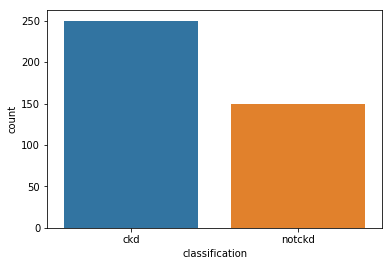

In [18]:
countplot = pd.DataFrame()
countplot['classification'] = data['classification']

countplot['classification'] = countplot['classification'].replace(0, 'ckd') 
countplot['classification'] = countplot['classification'].replace(1, 'notckd') 

ax = sns.countplot(x="classification", data=countplot)

We see that we have a lot more data with a positive diagnose than with a negative one, we can use the SMOTE algorithm at later point to create some synthetic values to have a well balanced dataset!

## Heatmap

A heatmap is a very easy and quick way to see correlation in our dataset, often it confirm our suggestions, often it shows us stuff which is logic but often the datasets are also strange, and so the heatmap is aswell:

In [19]:
pyo.init_notebook_mode()
data.drop('id', axis=1).corr().iplot(kind='heatmap',colorscale="blues", title="Feature Correlation Matrix")

We see some correlations higher .75 for the columns:
* classification and hemoglobin - as higher the hemoglobin value is as higher is the classifiction value(which is 1 for a desease and 0 for no desease)
lets look at these correlation a bit closer:


## Scatter plot


In [20]:
scatter_data = data[['classification', 'hemoglobin']]

scatter_data['classification'] = scatter_data['classification'].replace(0, 'ckd') 
scatter_data['classification'] = scatter_data['classification'].replace(1, 'notckd') 

scatter_data.iplot( kind="scatter"
                               , theme="white"
                               , x="classification"
                               , title='classification w/ hemoglobin'
                               , y="hemoglobin"
                               , categories="classification"
)

In [33]:
scatter_data_2 = data[['classification', 'packed_cell_volume']]

scatter_data_2['classification'] = scatter_data_2['classification'].replace(0, 'ckd') 
scatter_data_2['classification'] = scatter_data_2['classification'].replace(1, 'notckd') 

scatter_data_2.iplot(   kind="scatter"
                                     , theme="white"
                                     , x="classification"
                                     , title='classification w/ packed_cell_volume'
                                     , y="packed_cell_volume"
                                     , categories="classification"
)

This plot already gives us an  important information, we can say: If the hemoglobin or the packed cell volumn is low the person is more likely to have a kidney disease!

For the sake of completeness lets also look at **packed_cell_volume** w/ **hemoglobin**:

In [38]:
scatter_data_2 = data[['hemoglobin', 'packed_cell_volume']]

scatter_data_2.iplot(   kind="scatter"
                                     , x="packed_cell_volume"
                                     , title='hemoglobin w/ packed_cell_volume'
                                     , y="hemoglobin"
                                     , categories="hemoglobin"
)

Looks like a pretty good correlation, although we have quite some outliers, lets use a technique called **isolation forest** to check the outliers:

c:\users\jakob engl\anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



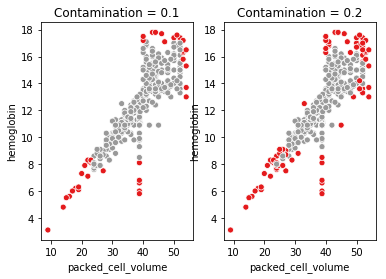

In [23]:
import sklearn
from sklearn.ensemble import IsolationForest
import seaborn as sns; 
import matplotlib.pyplot as plt
%matplotlib inline


# Predict and visualize outliers
data_if = data[['hemoglobin', 'packed_cell_volume']]

clf_s1 = IsolationForest(contamination=0.1, behaviour='new')
clf_s2 = IsolationForest(contamination=0.2, behaviour='new')

outliers_1 = clf_s1.fit_predict(data_if)
outliers_2 = clf_s2.fit_predict(data_if)


fig, ax =plt.subplots(1,2)
ax1 = sns.scatterplot(data_if.packed_cell_volume, data_if.hemoglobin, outliers_1, palette='Set1', legend=False, ax=ax[0])
ax1.set_title('Contamination = 0.1')

ax2 = sns.scatterplot(data_if.packed_cell_volume, data_if.hemoglobin, outliers_2, palette='Set1', legend=False, ax=ax[1])
ax2.set_title('Contamination = 0.2')
fig.show()


This shows us the outliers, depending on the contamination we define!

## 3D Plot

We saw the 3 features in a scatter plot seperated, lets check how they are gonna look all three together in a 3-Dimensional plot:

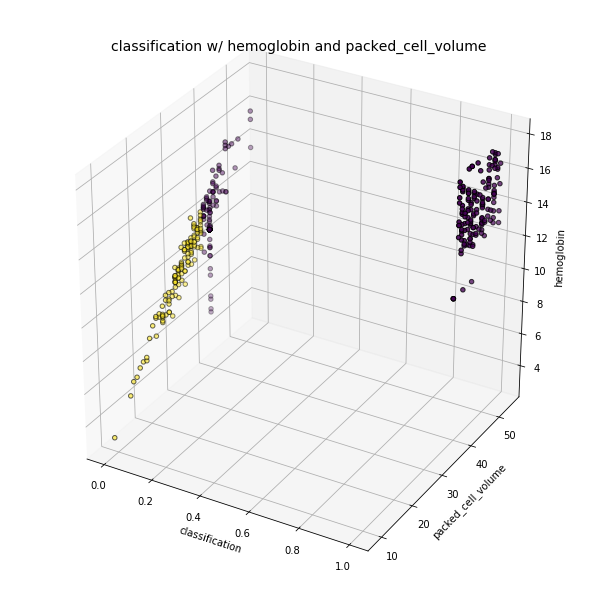

In [25]:
from mpl_toolkits.mplot3d import Axes3D

X = data[['classification', 'packed_cell_volume', 'hemoglobin']]
X = X.reset_index(drop=True)

km = KMeans(n_clusters=2)
km.fit(X)
km.predict(X)
labels = km.labels_

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig)

ax.scatter(X.iloc[:,0]
                 , X.iloc[:,1]
                 , X.iloc[:,2]
                 , c=labels.astype(np.float)
                 , edgecolor="k"
)

ax.set_xlabel("classification")
ax.set_ylabel("packed_cell_volume")
ax.set_zlabel("hemoglobin")

plt.title("classification w/ hemoglobin and packed_cell_volume", fontsize=14);

This shows us even more clear more, as lower hemoglobin and packed_cell_volume is as more likely it is that the person suffers from a kidney disease!

## Boxplot


Some boxplots, of the data, here comes again the strength of plotly to hand, we can simply zoom in to whichever boxplot we would like to have a closer look, try it out:

In [26]:
data.drop('id', axis=1).iplot(kind='box')

#### Visualisation of 5 most important features from RFE #####

TODO: do

#### Distrubution of Kidney Disease over Age ####

In general I would tend to say that older people are more afftected by diseases in general, lets check what our data has to say about that:

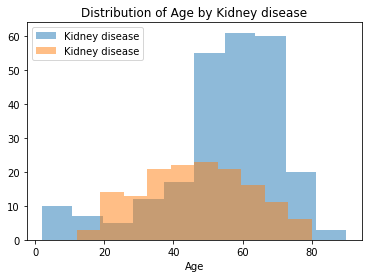

In [104]:
data_kidney_disease = data[data['classification'] == 0]
data_no_kidney_disease = data[data['classification'] == 1]

plt.hist(data=data_kidney_disease['age'], x=data_kidney_disease['age'], alpha=0.5, label='Kidney disease');
plt.hist(data=data_kidney_disease['age'], x=data_no_kidney_disease['age'], alpha=0.5, label='Kidney disease');
plt.title('Distribution of Age by Kidney disease');
plt.xlabel('Age');
plt.legend();

In [93]:
data_kidney_disease['age'].iplot(kind='histogram', bins=20,title='Kidney disease')
data_no_kidney_disease['age'].iplot(kind='histogram', bins=20,title='No kidney disease')

#data_no_kidney_disease[['classification', 'age']].iplot(kind='bar',title='PCA - Kidney Desease')

#data_no_kidney_disease['classification']

# Model

## Unsupervised Learning

### Clustering

Lets start with finding a good number of clusters for our dataset, we are gonna use the two different methods;
* silhouette score
* Elbow Method

#### silhouette_score ####

Silhouette score is one method to find a good number of clusters!

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.626773068427202
For n_clusters = 3 The average silhouette_score is : 0.5904817297622938
For n_clusters = 4 The average silhouette_score is : 0.5574307603962692
For n_clusters = 5 The average silhouette_score is : 0.5297799338081071
For n_clusters = 6 The average silhouette_score is : 0.540768253070337


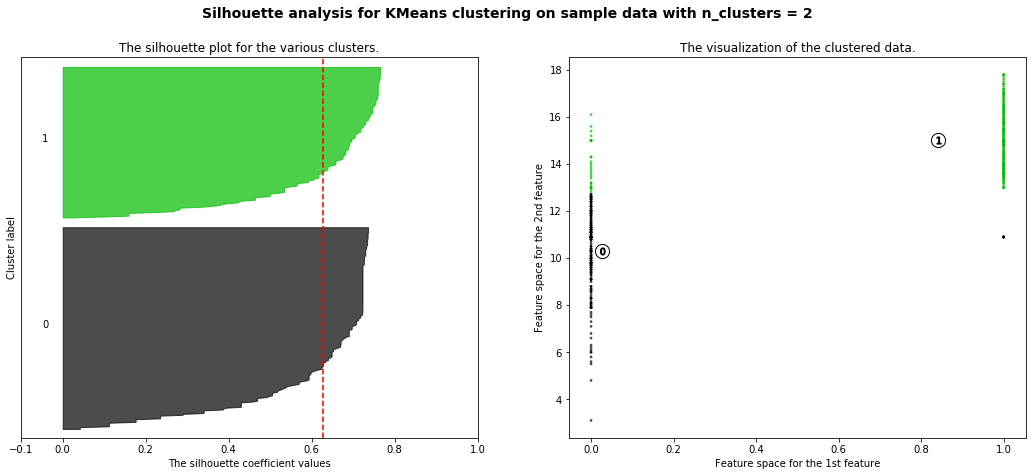

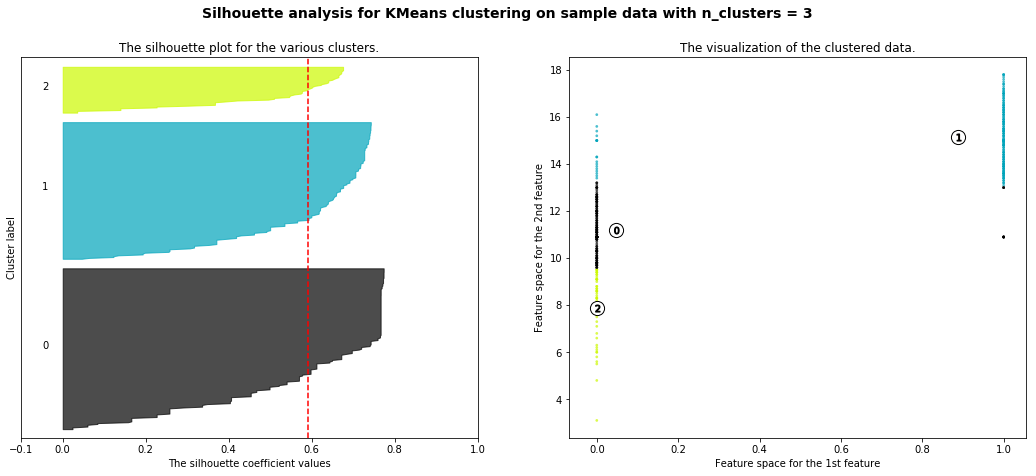

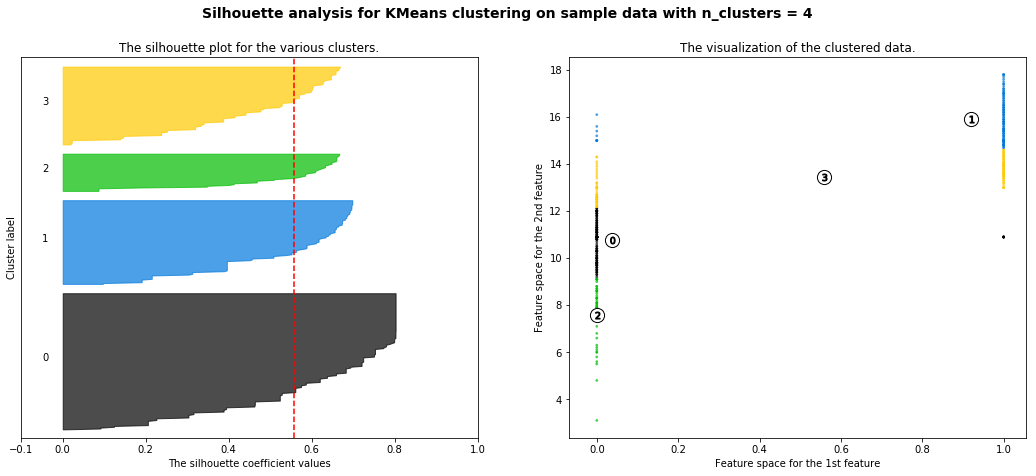

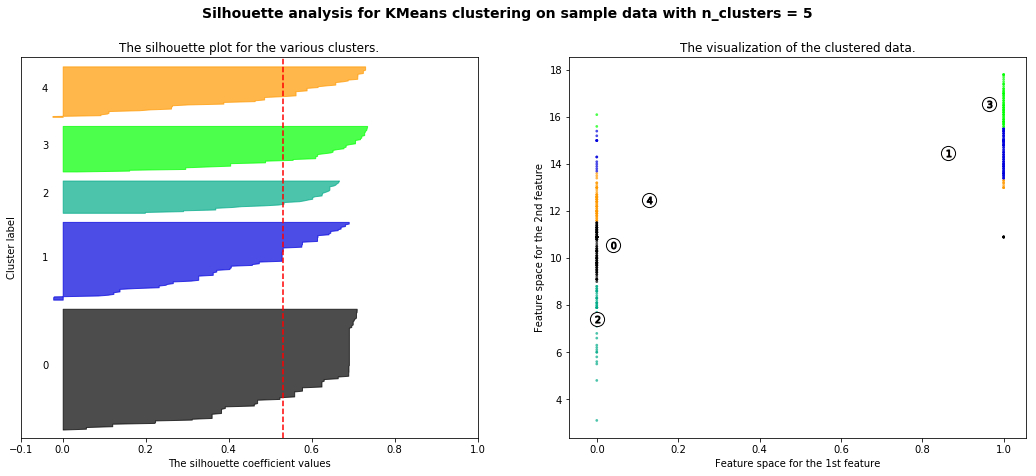

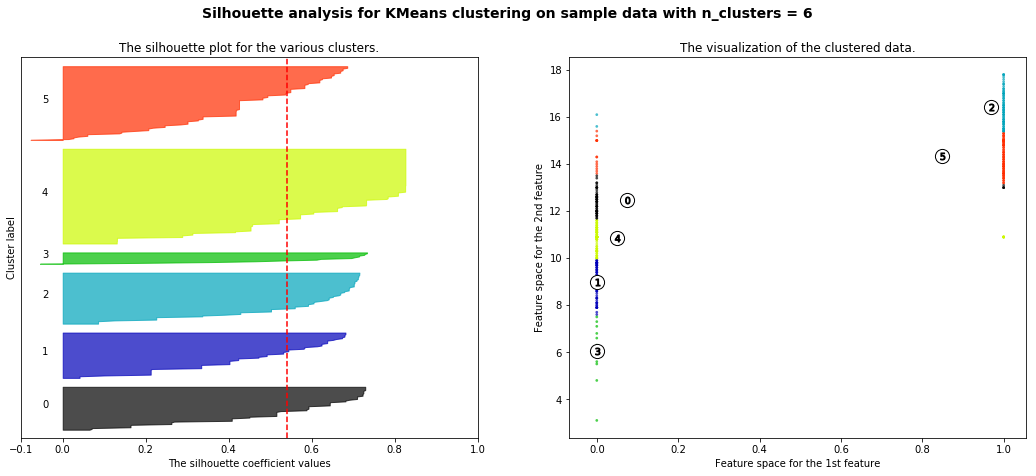

In [27]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

X = data[['classification', 'hemoglobin']].to_numpy()

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


#### Elbow Method ####

The elbow method presents us a graph which we can use to see how many features make sense and how many dont brings us a lot of insight:

In [28]:
from sklearn.cluster import KMeans
from pandas import DataFrame

#data_cluster = data.drop(['pus_cell_clumps', 'bacteria', 'diabetes_mellitus', 'hypertension', 'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia', 'classification'], axis=1)
data_cluster =  data[['classification', 'hemoglobin']]
n_cluster = range(1, 6)

kmeans = [KMeans(n_clusters=i).fit(data_cluster) for i in n_cluster]
scores = [kmeans[i].score(data_cluster) for i in range(len(kmeans))]

scores_df = DataFrame(scores)
scores_df.iplot(kind="scatter", theme="white")

The elbow point is at 2/ 3 clusters, thats good because this allows it to visualize it quiet easy, 4 gets tricky, 5 complicated and more dimensions are hard to understand for everybody not having a technical background:

In [29]:
data_cluster =  data[['classification', 'packed_cell_volume']]
n_cluster = range(1, 6)

kmeans = [KMeans(n_clusters=i).fit(data_cluster) for i in n_cluster]
scores = [kmeans[i].score(data_cluster) for i in range(len(kmeans))]

scores_df = DataFrame(scores)
scores_df.iplot(kind="scatter", theme="white")

Pretty much the same here!

In [30]:
data_cluster =  data[['classification', 'packed_cell_volume', 'hemoglobin']]
n_cluster = range(1, 6)

kmeans = [KMeans(n_clusters=i).fit(data_cluster) for i in n_cluster]
scores = [kmeans[i].score(data_cluster) for i in range(len(kmeans))]

scores_df = DataFrame(scores)
scores_df.iplot(kind="scatter", theme="white")

Similar here as well, a bit less steep though!